<a href="https://colab.research.google.com/github/DaffRazan/Lunion/blob/Azza-Liarista-Anggraini/Machine%20Learning/Deep%20Learning%20pendeteksi%20penyakit%20paru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acquiring data

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"azzaliaristaa","key":"8db4aa5d19a12986aaac0e7b75ad28fe"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.69G/3.69G [00:45<00:00, 66.6MB/s]
100% 3.69G/3.69G [00:46<00:00, 86.0MB/s]


In [5]:
!ls

files  kaggle.json  respiratory-sound-database.zip  sample_data


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('respiratory-sound-database.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()


Buat dataframe database suara paru

In [7]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
print(tf.__version__)

2.5.0


In [9]:
!python --version

Python 3.7.10


In [10]:
df_no_diagnosis = pd.read_csv('/content/files/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')

diagnosis = pd.read_csv('/content/files/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [11]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [12]:
df

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,NaN,19.0,99.0,URTI
1,102,0.75,F,NaN,9.8,73.0,Healthy
2,103,70.00,F,33.00,NaN,NaN,Asthma
3,104,70.00,F,28.47,NaN,NaN,COPD
4,105,7.00,F,NaN,32.0,135.0,URTI
...,...,...,...,...,...,...,...
121,222,60.00,M,NaN,NaN,NaN,COPD
122,223,NaN,NaN,NaN,NaN,NaN,COPD
123,224,10.00,F,NaN,32.3,143.0,Healthy
124,225,0.83,M,NaN,7.8,74.0,Healthy


In [13]:
root = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [14]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [15]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,151,2p3,Pr,mc,AKGC417L
0,203,1p3,Pr,mc,AKGC417L
0,138,1p2,Tc,mc,AKGC417L
0,172,1b4,Ar,mc,AKGC417L
0,183,1b1,Pl,sc,Meditron


In [16]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [17]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

,filename
0,225_1b1_Pl_sc_Meditron
1,200_3p4_Pl_mc_AKGC417L
2,104_1b1_Ar_sc_Litt3200
3,223_1b1_Pr_sc_Meditron
4,192_2b1_Al_mc_LittC2SE
...,...
915,151_2p3_Pr_mc_AKGC417L
916,203_1p3_Pr_mc_AKGC417L
917,138_1p2_Tc_mc_AKGC417L
918,172_1b4_Ar_mc_AKGC417L


In [18]:
audio_path = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

In [19]:
# adding columns in file_label_df
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []
for i in range(len(file_label_df['filename'])):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info
  sound_filename = audio_path + file_label_df['filename'][i] + '.wav'
  x, sr = librosa.load(sound_filename)
  dur = round(x.shape[0]/sr, 2)
  sample_rate.append(sr)
  duration.append(dur)
  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment
file_label_df['duration'] = duration
file_label_df['sample rate'] = sample_rate

In [20]:
diagnosis_3 = []
for i in range(len(file_label_df['Diagnosis'])):
  diagnosis = file_label_df['Diagnosis'][i]
  if diagnosis == 'COPD' or diagnosis == 'Bronchiectasis' or diagnosis == 'Asthma':
    diagnosis_3.append('Chronic Disease')
  elif diagnosis == 'URTI' or diagnosis == 'LRTI' or diagnosis == 'Pneumonia' or diagnosis == 'Bronchiolitis':
    diagnosis_3.append('Non-Chronic Disease')
  else:
    diagnosis_3.append('Healthy')

file_label_df['3 label diagnosis'] = diagnosis_3

In [21]:
file_label_df

,filename,Diagnosis,Patient Number,Chest Location,Acquisition Mode,Recording Equipment,duration,sample rate,3 label diagnosis
0,225_1b1_Pl_sc_Meditron,Healthy,225,Pl,sc,Meditron,20.00,22050,Healthy
1,200_3p4_Pl_mc_AKGC417L,COPD,200,Pl,mc,AKGC417L,20.00,22050,Chronic Disease
2,104_1b1_Ar_sc_Litt3200,COPD,104,Ar,sc,Litt3200,25.58,22050,Chronic Disease
3,223_1b1_Pr_sc_Meditron,COPD,223,Pr,sc,Meditron,32.90,22050,Chronic Disease
4,192_2b1_Al_mc_LittC2SE,COPD,192,Al,mc,LittC2SE,20.00,22050,Chronic Disease
...,...,...,...,...,...,...,...,...,...
915,151_2p3_Pr_mc_AKGC417L,COPD,151,Pr,mc,AKGC417L,20.00,22050,Chronic Disease
916,203_1p3_Pr_mc_AKGC417L,COPD,203,Pr,mc,AKGC417L,20.00,22050,Chronic Disease
917,138_1p2_Tc_mc_AKGC417L,COPD,138,Tc,mc,AKGC417L,20.00,22050,Chronic Disease
918,172_1b4_Ar_mc_AKGC417L,COPD,172,Ar,mc,AKGC417L,20.00,22050,Chronic Disease


In [22]:
file_label_df['Diagnosis'].value_counts()

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: Diagnosis, dtype: int64

In [23]:
file_label_df['3 label diagnosis'].value_counts()

Chronic Disease        810
Non-Chronic Disease     75
Healthy                 35
Name: 3 label diagnosis, dtype: int64

In [24]:
file_label_df['duration'].value_counts()

20.00    817
30.00      6
14.58      4
19.63      3
71.05      2
        ... 
26.93      1
20.08      1
15.47      1
19.83      1
86.20      1
Name: duration, Length: 74, dtype: int64

In [25]:
file_label_df['sample rate'].value_counts()

22050    920
Name: sample rate, dtype: int64

# Exploratory Data Analysis 

In [26]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read

In [27]:
audio_path = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
i = 100
sound_filename = audio_path + file_label_df['filename'][i] + '.wav'

In [28]:
import IPython.display as ipd
ipd.Audio(sound_filename)

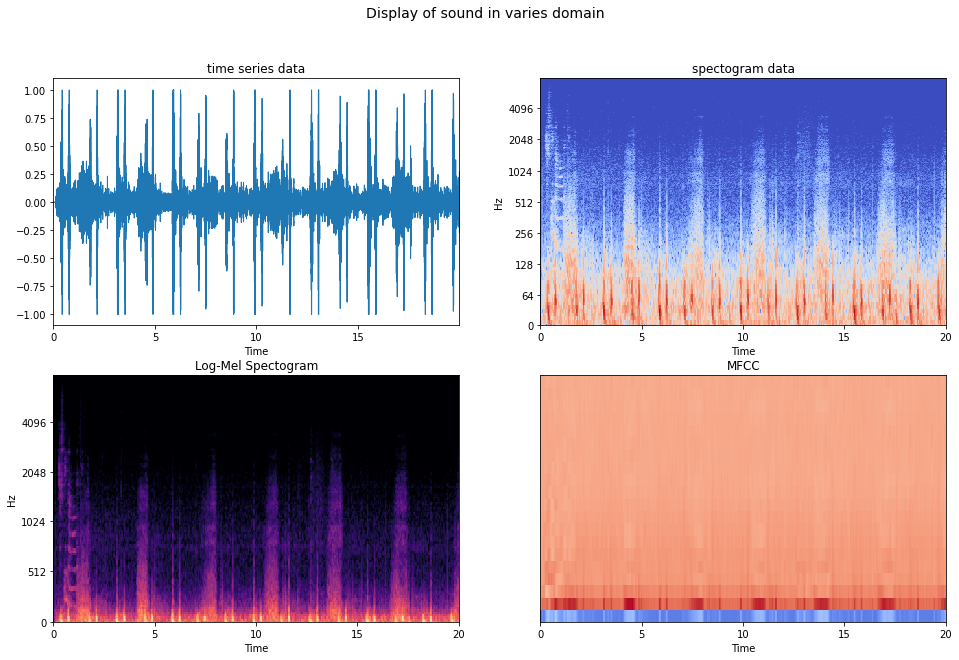

In [30]:
# Displaying sound data 
"""
  time series : amplitude of sound is varied in time domain (1D)
  spectogram : amplitude of sound is varied in time and frequency domain (2D)
"""
# time series data
sr_new = 16000 # resample 16 kHz
x, sr = librosa.load(sound_filename, sr=sr_new) # x : time series data, sr : sample rate

# Spectogram data 
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

# Log-mel spectogram
mel = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128, fmax=8000)
log_mel = librosa.power_to_db(mel, ref=np.max)


# Mel-Frequency Cepstral Coefficient (MFCC)
mfccs = librosa.feature.mfcc(x, sr=sr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

librosa.display.waveplot(y=x, sr=sr, ax=ax[0, 0])
ax[0, 0].set(title='time series data')

librosa.display.specshow(Xdb, x_axis='time',
                         y_axis='log', sr=sr, ax=ax[0, 1])
ax[0, 1].set(title='spectogram data')

librosa.display.specshow(log_mel, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax[1, 0])
ax[1, 0].set(title='Log-Mel Spectogram')


librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax[1, 1])
ax[1, 1].set(title='MFCC')

plt.suptitle("Display of sound in varies domain", fontsize=14);


In [31]:
mfccs.shape

(20, 626)

# Preprocessing

In [32]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)

    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 20 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(x, sr=sr_new)
    
    elif mode == 'log_mel':
      feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
      feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [33]:
from tqdm.notebook import tqdm
# apply preprocessing to sound data
preprocessed_data = []
labels = []
labels_3 = []
for i in tqdm(range(len(file_label_df['filename']))):
  audio_file = audio_path + file_label_df['filename'][i] + '.wav'
  data = preprocessing(audio_file, mode = 'mfcc')
  preprocessed_data.append(data)
  labels.append(file_label_df['Diagnosis'][i])
  labels_3.append(file_label_df['3 label diagnosis'][i])
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
labels_3 = np.array(labels_3)



In [35]:
# Reshape data to suit input of model
preprocessed_data = preprocessed_data.reshape((-1, 20, 626, 1))

In [36]:
# one hot encoding labels
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels) 

encoder_3 = LabelEncoder()
i_labels_3 = encoder_3.fit_transform(labels_3)
oh_labels_3 = to_categorical(i_labels_3) 

In [37]:
print(list(encoder_3.classes_))

['Chronic Disease', 'Healthy', 'Non-Chronic Disease']


In [38]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(preprocessed_data, oh_labels_3, stratify=oh_labels_3, 
                                                    test_size=0.2, random_state = 42)

# Training and Testing

Metric : Accuracy, waktu komputasi prediksi 

In [60]:
from keras.layers.normalization import BatchNormalization

num_rows = 20
num_columns = 626
num_channels = 1


num_labels = oh_labels_3.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu')) 

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu')) 

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 19, 625, 16)       80        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 9, 312, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 9, 312, 16)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 9, 312, 64)        1088      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 311, 32)        8224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 4, 155, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 4, 155, 32)       

In [61]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [62]:
# train model
num_epochs = 100
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
12/12 [==============================] - 11s 857ms/step - loss: 1.1494 - accuracy: 0.8016 - val_loss: 0.5912 - val_accuracy: 0.8533

Epoch 00001: val_accuracy improved from -inf to 0.85326, saving model to mymodel2_01.h5
Epoch 2/100
12/12 [==============================] - 10s 816ms/step - loss: 0.5258 - accuracy: 0.8668 - val_loss: 0.4600 - val_accuracy: 0.8804

Epoch 00002: val_accuracy improved from 0.85326 to 0.88043, saving model to mymodel2_02.h5
Epoch 3/100
12/12 [==============================] - 10s 823ms/step - loss: 0.4387 - accuracy: 0.8723 - val_loss: 0.4184 - val_accuracy: 0.8804

Epoch 00003: val_accuracy did not improve from 0.88043
Epoch 4/100
12/12 [==============================] - 10s 813ms/step - loss: 0.4147 - accuracy: 0.8736 - val_loss: 0.3956 - val_accuracy: 0.8859

Epoch 00004: val_accuracy improved from 0.88043 to 0.88587, saving model to mymodel2_04.h5
Epoch 5/100
12/12 [==============================] - 10s 810ms/step - loss: 0.4134 - accuracy: 

<Figure size 432x288 with 0 Axes>

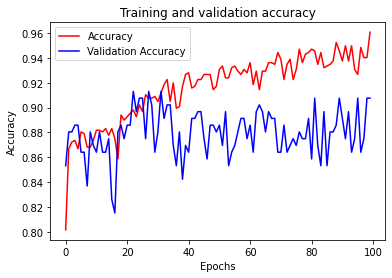

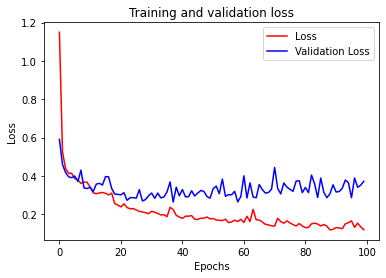

<Figure size 432x288 with 0 Axes>

In [63]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [64]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9510869383811951
Testing Accuracy:  0.907608687877655


In [65]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=3 # number of classes

In [66]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

c_names = ['Chronic Disease', 'Healthy', 'Non-Chronic Disease']

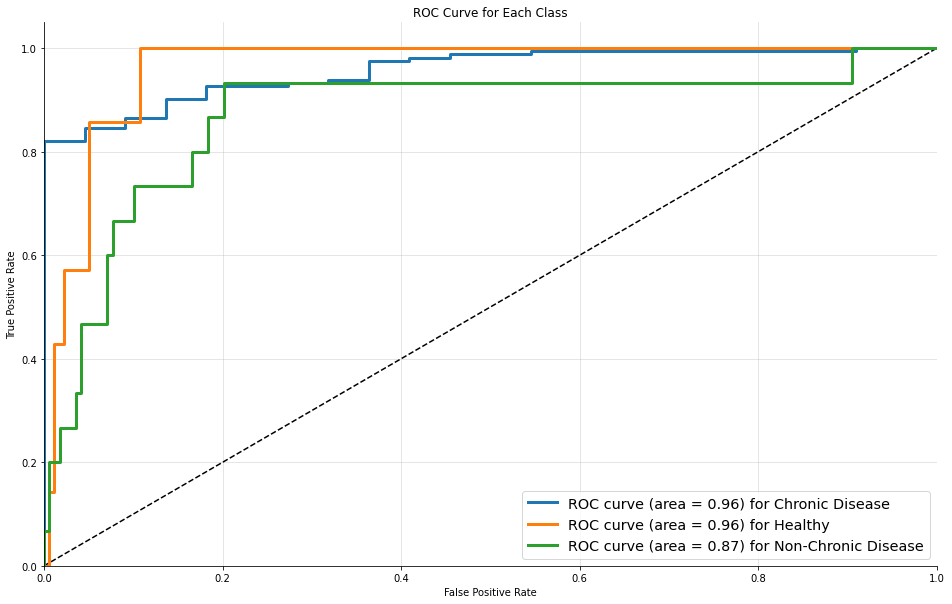

In [67]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [68]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

                     precision    recall  f1-score   support

    Chronic Disease       0.95      0.98      0.96       162
            Healthy       0.43      0.43      0.43         7
Non-Chronic Disease       0.56      0.33      0.42        15

           accuracy                           0.91       184
          macro avg       0.64      0.58      0.60       184
       weighted avg       0.89      0.91      0.90       184



In [69]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[159   2   1]
 [  1   3   3]
 [  8   2   5]]


Save model as saved model format

In [70]:
export_dir = 'saved_model/my_model'

tf.saved_model.save(model, export_dir=export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


# Prediksi suara paru

In [86]:
# Here's a codeblock just for fun. You should be able to upload an sound here 
# and have it classified without crashing
from google.colab import files

# uploading data
uploaded = files.upload()
fn = list(uploaded.keys())

Saving 107_2b3_Ar_mc_AKGC417L.wav to 107_2b3_Ar_mc_AKGC417L.wav


In [87]:
# load model
# Recreate the exact same model, including its weights and the optimizer
model_path = 'saved_model/my_model'
new_model = tf.keras.models.load_model(model_path)

# Show the model architecture
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 19, 625, 16)       80        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 9, 312, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 9, 312, 16)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 9, 312, 64)        1088      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 311, 32)        8224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 4, 155, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 4, 155, 32)       

In [88]:
audio_path = '/content/files/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

In [89]:
import numpy as np
import librosa

i = 3
audio_file = audio_path + file_label_df['filename'][i] + '.wav'

# preprocessing sound
data = preprocessing(audio_file, mode='mfcc')
data = np.array(data)
data = data.reshape((20, 626, 1))
data = np.expand_dims(data, axis=0)

datas = np.vstack([data])

# Predict sound data
classes = new_model.predict(datas, batch_size=10)
idx = np.argmax(classes)

c_names = ['Chronic Disease', 'Healthy', 'Non-Chronic Disease']
print('Lunion prediction: \n{}'.format(c_names[idx]))
print('Actual label: \n{}'.format(file_label_df['3 label diagnosis'][i]))
print('Confidence Percentage: {:.2f} %'.format(np.max(classes) * 100))

Lunion prediction: 
Chronic Disease
Actual label: 
Chronic Disease
Confidence Percentage: 67.54 %


# Integration with mobile

In [ ]:
import pathlib

In [ ]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)# YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

17600

In [ ]:
# download saved_model
!zip -r /content/saved_model.zip /content/saved_model
from google.colab import files
files.download("/content/saved_model.zip")

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 65%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/my_model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>